In [29]:
"""IMPORT BIBLIOTEK"""
import mne 
import matplotlib.pyplot as plt
import numpy as np 
from mne.preprocessing import ICA, create_eog_epochs, create_ecg_epochs #funkcje ica
from mne_icalabel import label_components #ica-label algorytm
import onnxruntime #biblioteka do obsługi ica-label
#backend matplotliba 
%matplotlib qt 

"""WSTĘPNE USTAWIENIA PRZED WCZYTANIEM SYGNAŁU"""
d_path = "eeg_files/20241017_kp.bdf" #ścieżka do pliku
ch_eog = ["EXG1","EXG2"] #zdefiniowanie dedykowanych kanałów EOG
ch_ecg = ["EXG3","EXG4"] #zdefiniowanie dedykowanych kanałów ECG
ch_exclude = [f"EXG{i}" for i in range(5,9)] #wykluczenie kanałów niewykorzystanych w badaniu

"""ZAŁADOWANIE SYGNAŁU I USTAWIENIE UKŁADU ELEKTROD"""
raw_original = mne.io.read_raw_bdf(
    d_path, preload = True, eog = ch_eog, misc = ch_ecg, exclude = ch_exclude 
)
raw_original.set_montage("biosemi64")
raw_original.set_eeg_reference(projection=True)

Extracting EDF parameters from /Users/szymbierz/Desktop/wszystko/notebooks/statystyka/inne/eeg/eeg_files/20241017_kp.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2928639  =      0.000 ...  1430.000 secs...
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.


<RawEDF | 20241017_kp.bdf, 69 x 2928640 (1430.0 s), ~1.51 GiB, data loaded>

In [31]:
raw = raw_original.copy()
raw.filter(l_freq=1,h_freq=45)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 6759 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


<RawEDF | 20241017_kp.bdf, 69 x 2928640 (1430.0 s), ~1.51 GiB, data loaded>

Using matplotlib as 2D backend.


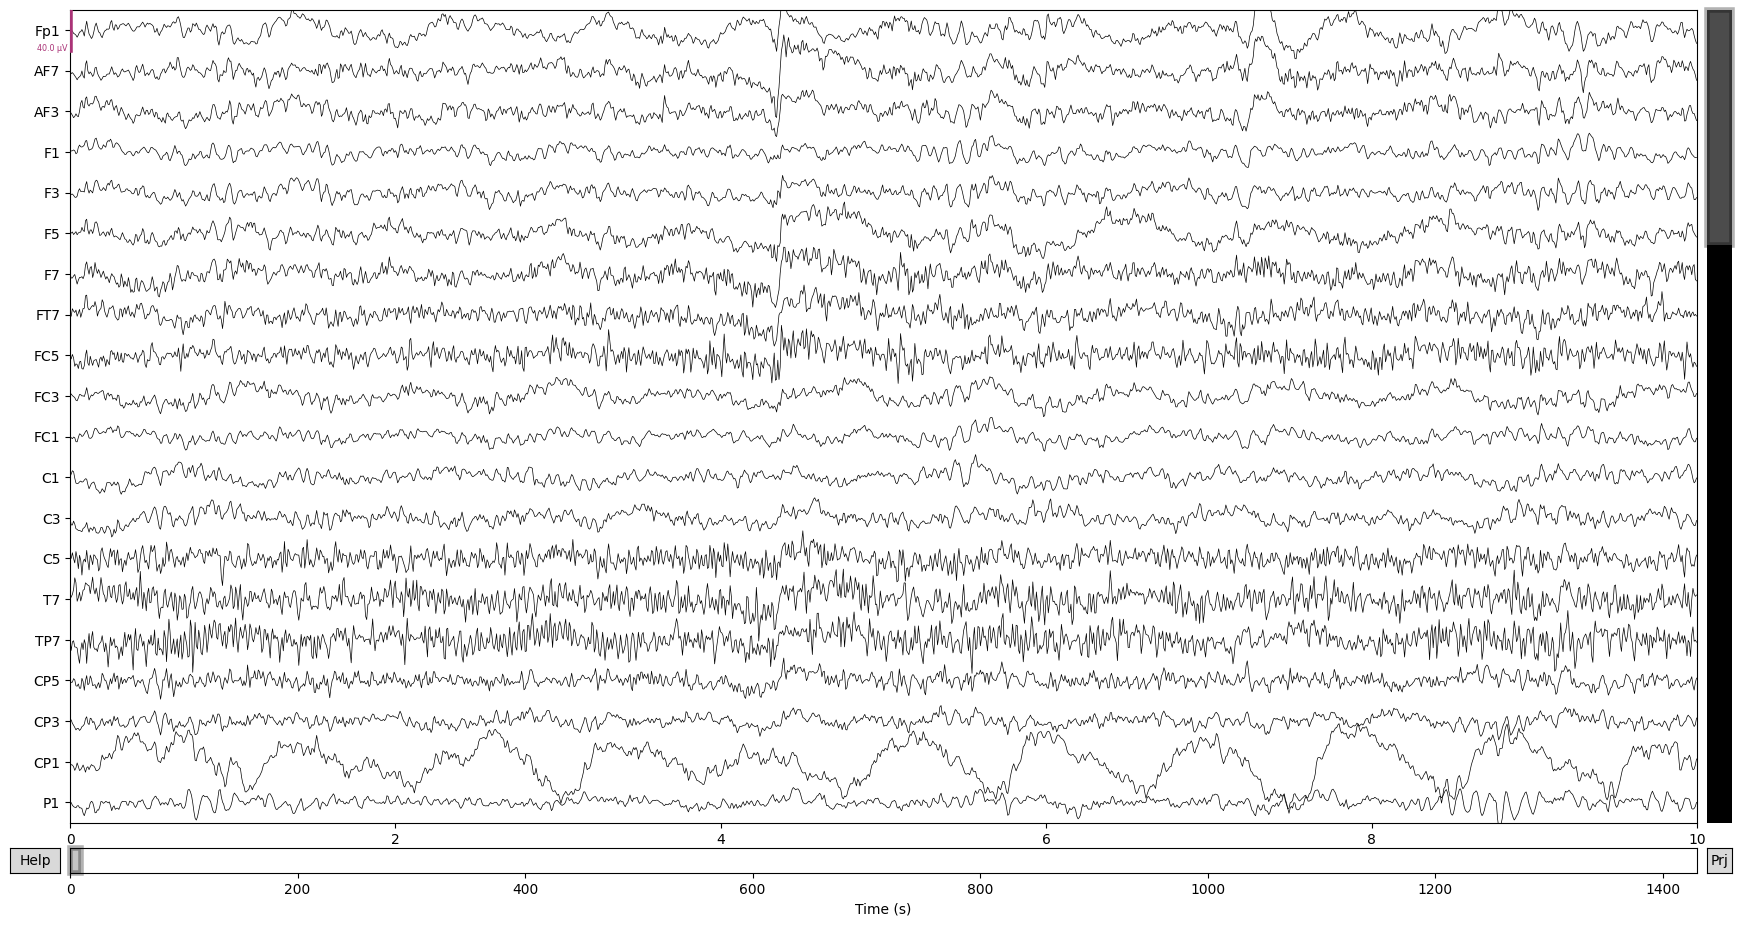

Channels marked as bad:
[np.str_('AFz'), np.str_('CP1')]


In [32]:
raw.plot()

In [33]:
raw.interpolate_bads()

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 62 sensor positions
Interpolating 2 sensors


<RawEDF | 20241017_kp.bdf, 69 x 2928640 (1430.0 s), ~1.51 GiB, data loaded>

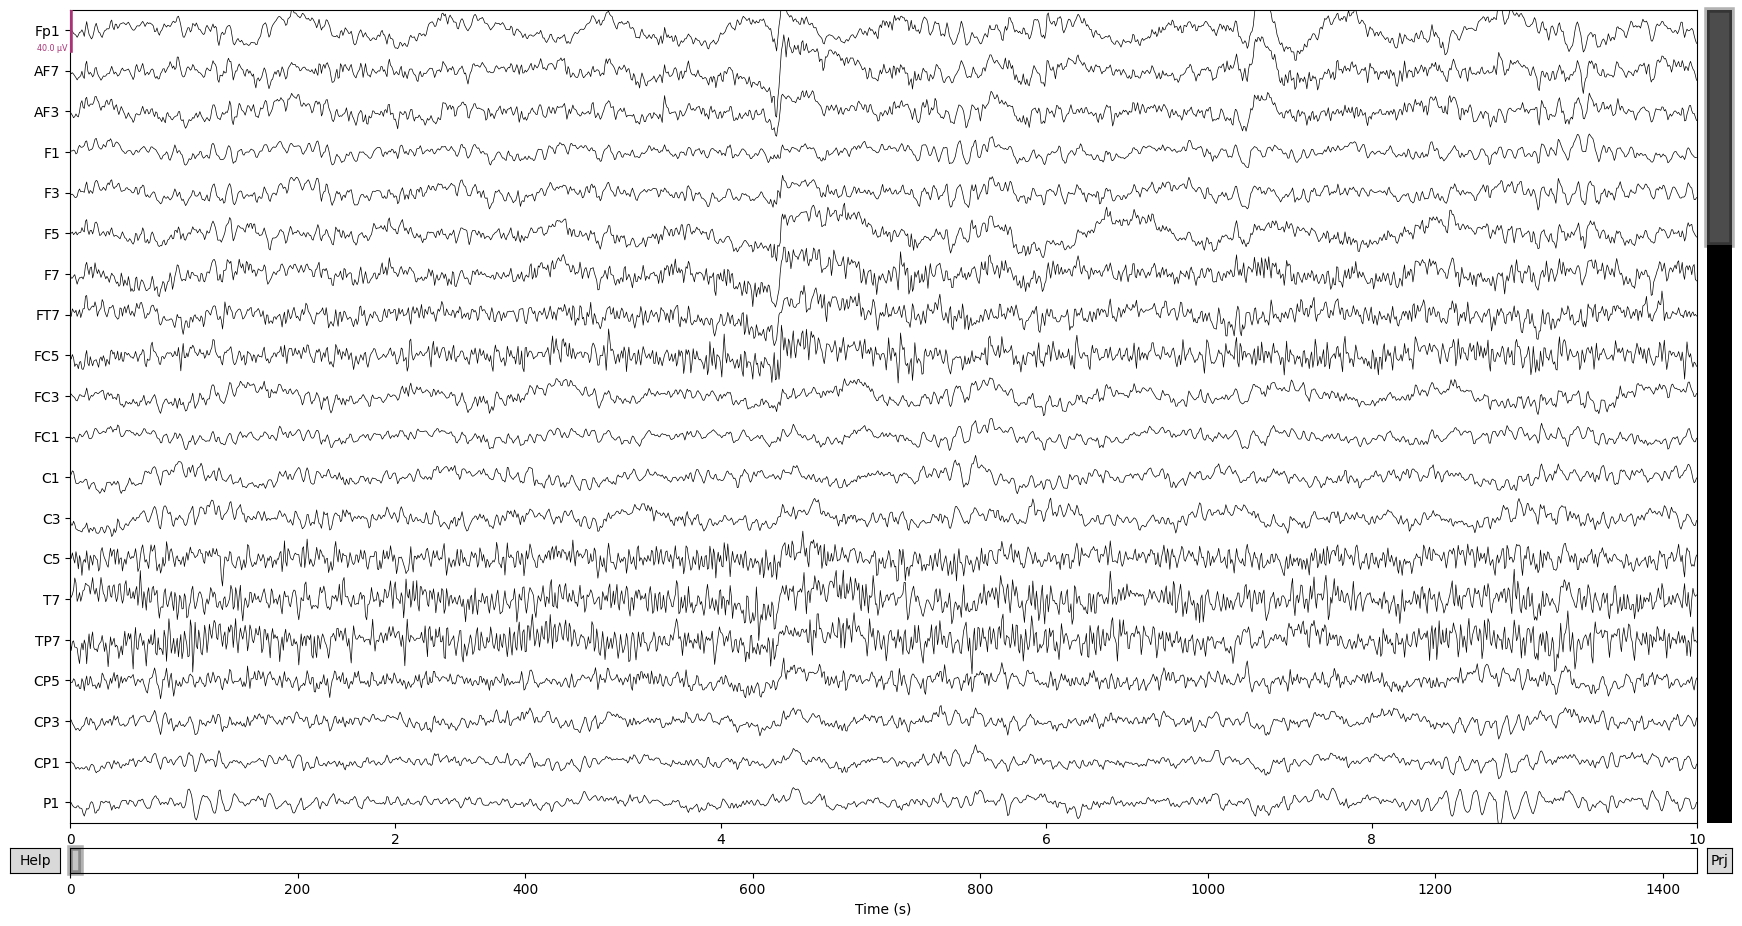

Channels marked as bad:
none


In [34]:
raw.plot()

In [35]:
eog_evoked = create_eog_epochs(raw).average(picks="eeg")
eog_evoked.apply_baseline((None, None))

Using EOG channels: EXG1, EXG2
EOG channel index for this subject is: [64 65]
Omitting 2456 of 2928640 (0.08%) samples, retaining 2926184 (99.92%) samples.
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EXG2 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 20480 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 419 significant peaks
Number of EOG events detected: 419
Not setting metadata
419 matching events found
No baseline correction applied
Created an SSP operator (subspace dim

<Evoked | '998' (average, N=419), -0.5 – 0.5 s, baseline -0.5 – 0.5 s, 64 ch, ~1.1 MiB>

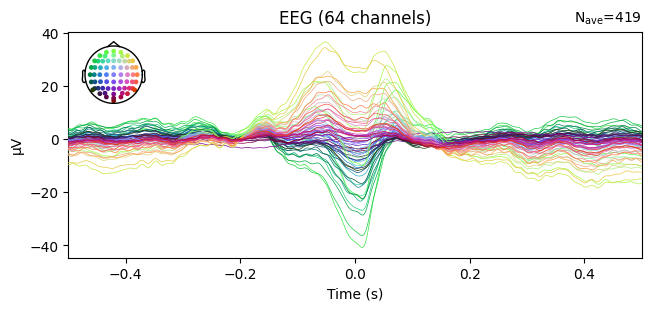

2025-05-16 15:09:24.618 Python[40123:14648509] _TIPropertyValueIsValid called with 16 on nil context!
2025-05-16 15:09:24.618 Python[40123:14648509] imkxpc_getApplicationProperty:reply: called with incorrect property value 16, bailing.
2025-05-16 15:09:24.618 Python[40123:14648509] Text input context does not respond to _valueForTIProperty:


In [37]:
eog_evoked.plot()

In [39]:
raw_filt = raw.copy().filter(l_freq=1.0, h_freq=45)
ica = ICA(n_components=None, method='fastica', random_state=97, max_iter='auto')
ica.fit(raw_filt,reject_by_annotation=True)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 6759 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


Fitting ICA to data using 64 channels (please be patient, this may take a while)
Omitting 2456 of 2928640 (0.08%) samples, retaining 2926184 (99.92%) samples.
Selecting by non-zero PCA components: 62 components
Fitting ICA took 70.0s.


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,51 iterations on raw data (2926184 samples)
ICA components,62
Available PCA components,64
Channel types,eeg
ICA components marked for exclusion,—


In [44]:
ica.plot_components()

[<MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 390x260 with 2 Axes>]

In [41]:
eog_epochs_for_detection = create_eog_epochs(raw_filt)


Using EOG channels: EXG1, EXG2
EOG channel index for this subject is: [64 65]
Omitting 2456 of 2928640 (0.08%) samples, retaining 2926184 (99.92%) samples.
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EXG2 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 20480 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 419 significant peaks
Number of EOG events detected: 419
Not setting metadata
419 matching events found
No baseline correction applied
Created an SSP operator (subspace dim

In [42]:
eog_indices, eog_scores = ica.find_bads_eog(eog_epochs_for_detection, ch_name=ch_eog)

Using EOG channels: EXG1, EXG2


In [43]:
print(eog_indices)

[np.int64(2), np.int64(7), np.int64(0)]


In [48]:
ecg_epochs_for_detection = create_ecg_epochs(raw_filt,ch_name="EXG3")

Using channel EXG3 to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 20480 samples (10.000 s)

Number of ECG events detected : 1375 (average pulse 57.740729906253335 / min.)
Not setting metadata
1375 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
Using data from preloaded Raw for 1375 events and 2049 original time points ...
2 bad epochs dropped


In [49]:
ecg_indices, ecg_scores = ica.find_bads_ecg(ecg_epochs_for_detection, ch_name="EXG3")
print(ecg_indices)

Using threshold: 0.12 for CTPS ECG detection
[np.int64(8), np.int64(23), np.int64(51), np.int64(7), np.int64(10)]


In [50]:
emg_indices,emg_scores = ica.find_bads_muscle(raw_filt)
print(emg_indices)

Setting 2456 of 2928640 (0.08%) samples to NaN, retaining 2926184 (99.92%) samples.
Effective window size : 1.000 (s)
[4, 7, 9, 10, 13, 15, 16, 17, 19, 20, 21, 24, 26, 27, 28, 29, 31, 34, 36, 37, 38, 39, 40, 41, 43, 45, 46, 49, 51, 52, 55, 57]


In [55]:
ica.exclude = [8,23,51,7,10,2,7,0,4,7,9,10,13,15,16,17,19,20,21,24,26,27,28,29,31,34,37,38,39,40,41,43,45,46,49,51,52,55,57]
print(ica.exclude)

[8, 23, 51, 7, 10, 2, 7, 0, 4, 7, 9, 10, 13, 15, 16, 17, 19, 20, 21, 24, 26, 27, 28, 29, 31, 34, 37, 38, 39, 40, 41, 43, 45, 46, 49, 51, 52, 55, 57]


In [56]:
raw_filtered = raw_filt.copy()


In [57]:
ica.apply(raw_filtered,exclude=ica.exclude)


Applying ICA to Raw instance
    Transforming to ICA space (62 components)
    Zeroing out 35 ICA components
    Projecting back using 64 PCA components


<RawEDF | 20241017_kp.bdf, 69 x 2928640 (1430.0 s), ~1.51 GiB, data loaded>

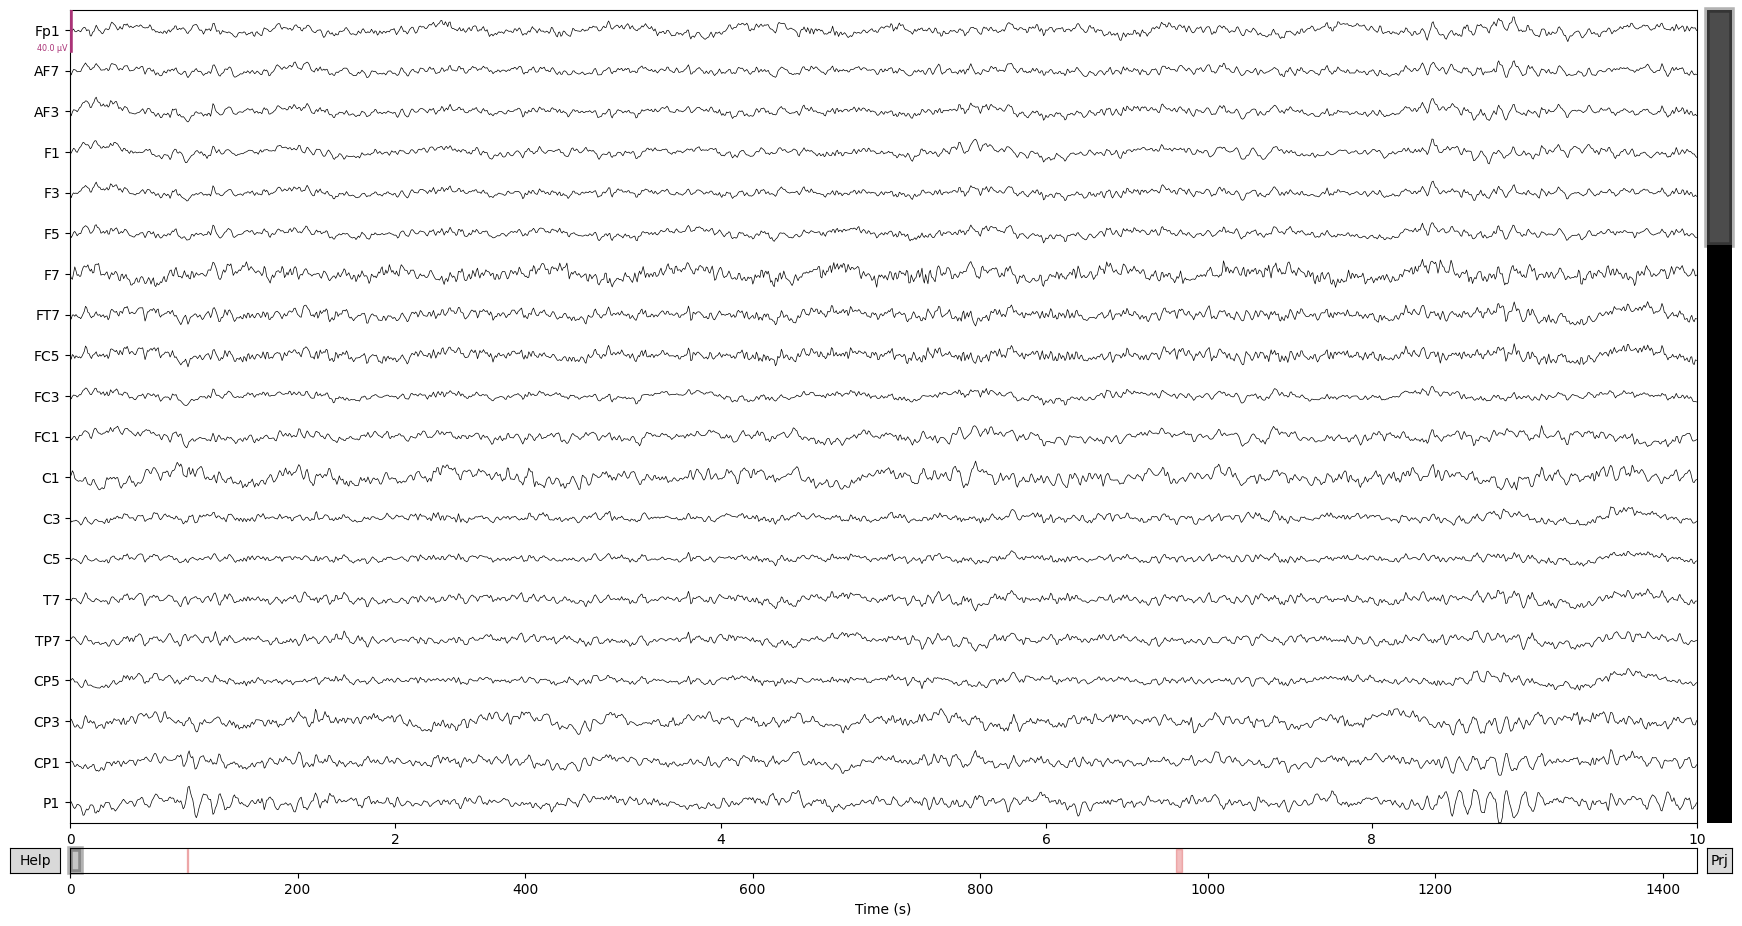

Channels marked as bad:
none


In [59]:
raw_filtered.plot()

In [63]:
raw_filtered.crop(0,950)
raw.set_eeg_reference('average')

<RawEDF | 20241017_kp.bdf, 69 x 2928640 (1430.0 s), ~1.51 GiB, data loaded>

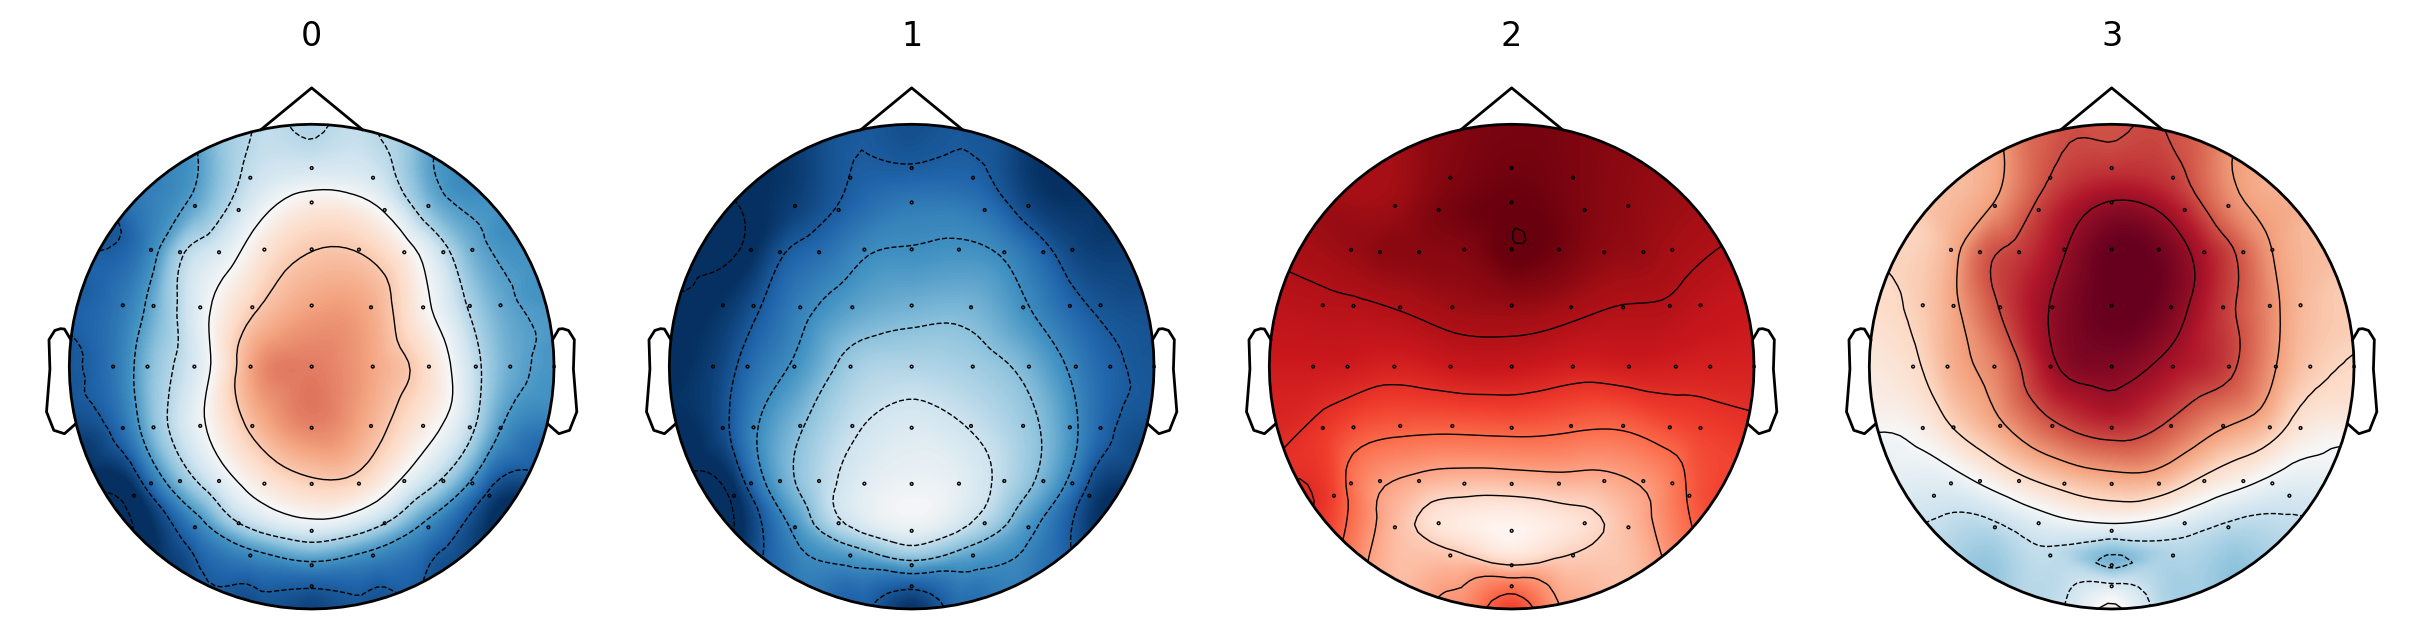

In [64]:
from pycrostates.preprocessing import extract_gfp_peaks
from pycrostates.cluster import ModKMeans
gfp_data = extract_gfp_peaks(raw_filtered, min_peak_distance=3)
ModK = ModKMeans(n_clusters=4, random_state=42)
ModK.fit(gfp_data, n_jobs=10, verbose="WARNING")
ModK.plot()

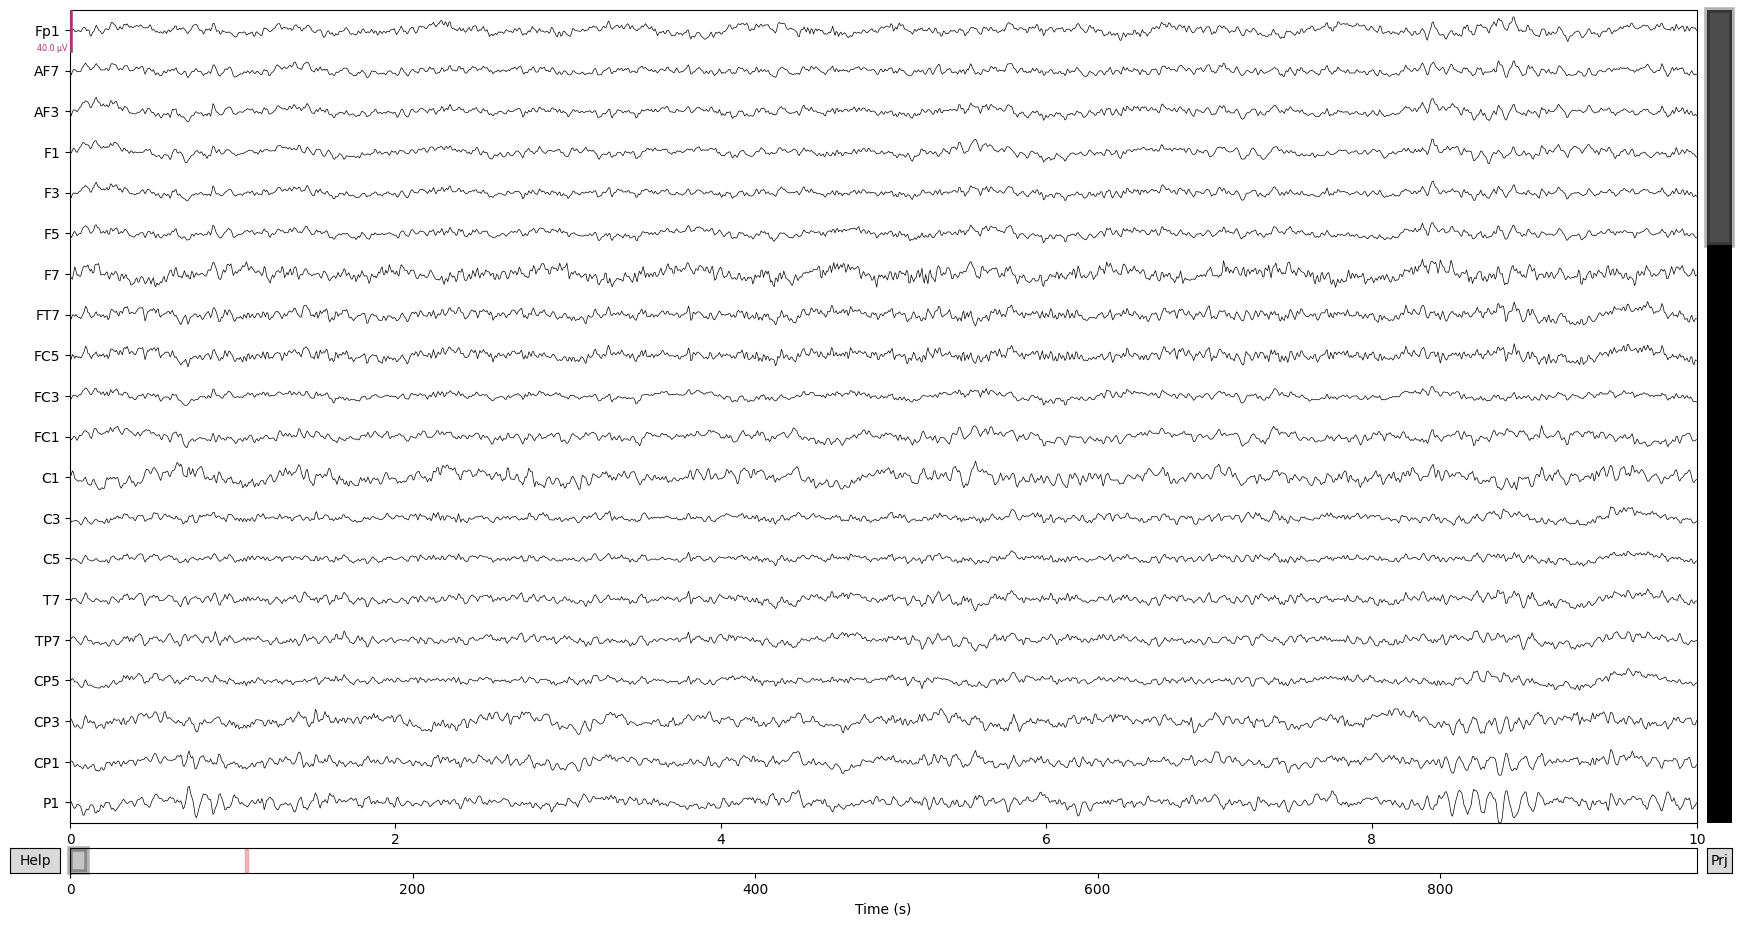

In [70]:
raw_filtered.plot()

In [81]:
data_cropped = raw_filtered.copy()
data_cropped.crop(tmin=0, tmax=100)
data_cropped.plot(duration=10, n_channels=30, scalings=dict(eeg=50e-6)) # Dostosuj parametry plot
plt.show()


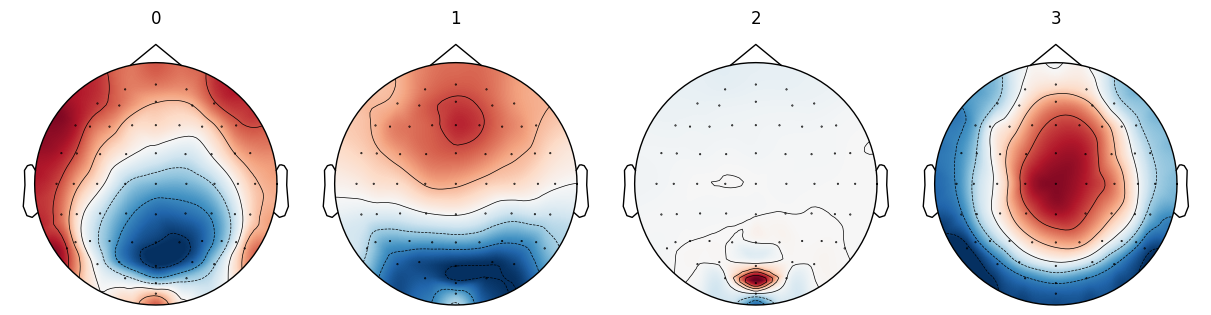

Exception ignored in: <function ResourceTracker.__del__ at 0x103b674c0>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x10359b4c0>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versi

In [76]:
epochs = mne.make_fixed_length_epochs(raw_filtered, duration=2, preload=True)
gfp_data = extract_gfp_peaks(epochs, min_peak_distance=3)
ModK = ModKMeans(n_clusters=4, random_state=42)
ModK.fit(gfp_data, n_jobs=10, verbose="WARNING")
ModK.plot()

In [ ]:
epochs = mne.make_fixed_length_epochs(raw_filtered, duration=2, preload=True)
gfp_data = extract_gfp_peaks(epochs, min_peak_distance=3)
ModK = ModKMeans(n_clusters=4, random_state=42)
ModK.fit(gfp_data, n_jobs=10, verbose="WARNING")
ModK.plot()